In [1]:
import numpy as np
import h5py

In [2]:
import os
print(os.getcwd())

c:\Users\noush\OneDrive\Noushath Data\Research\Deep Learning Codes\Python Projects\IJNS2023\DLAlgos\ResNet50


In [2]:
def load_OASIS():
    with h5py.File('..\..\Datasets\OASIS_balanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('trainX'))
        trainY = np.array(G1.get('trainY'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('testX'))
        testY = np.array(G2.get('testY'))

        return trainX, trainY, testX, testY

In [3]:
def load_ADNI():
    with h5py.File('..\..\Datasets\ADNI_enhanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [4]:
#dataset = 'ADNI'
dataset = 'ADNI'
# read the data which is also normalized.
if dataset == 'ADNI':
    x_train, y_train, x_test, y_test = load_ADNI()
else:
    x_train, y_train, x_test, y_test = load_OASIS()

print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)

(940, 218, 182, 1) (940,) (105, 218, 182, 1) (105,)


In [5]:
#Dataset ready for deep learning
from tensorflow.keras.utils import to_categorical
#x_train = np.expand_dims(x_train, axis=-1)
x_train = np.repeat(x_train, 3, axis=3)

#x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 3, axis=3)

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

print("Test",x_test.shape)
print ("Train",x_train.shape)
print(y_train.shape)
print (y_train_cat.shape)
print (y_test_cat.shape)
#print(np.max(x_train[0])) #to ensure that the values are within the range [0,1]


Test (105, 218, 182, 3)
Train (940, 218, 182, 3)
(940,)
(940, 4)
(105, 4)


In [7]:
print(x_test.shape)
print()
epochs = 10 #hyperparameter
num_classes=4


(105, 218, 182, 3)



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, MaxPooling2D, Activation, BatchNormalization
import tensorflow as tf
resnet_model = Sequential()


pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   #input_shape=(176,176,3),
                   input_shape=(218,182,3),
                   pooling='avg',classes=4,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Dropout(0.5))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(2048,kernel_initializer='he_uniform'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(1024,kernel_initializer='he_uniform'))
resnet_model.add(BatchNormalization())
resnet_model.add(Activation('relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(4,activation='softmax'))
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [9]:
METRIC = tf.keras.metrics.AUC(name = 'acc')
from tensorflow.keras.optimizers import Adam # optimizer hyperparameter
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=METRIC) #learning rate hyperparameter.


In [10]:
filepath = 'best_weights.hdf5'
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)
callback_list = [earlystopping, checkpoint]



In [11]:
#training
#batch_size hyperparamter.
history=resnet_model.fit(x_train, y_train_cat, batch_size = 128, epochs = 200, verbose = 1, validation_data = (x_test, y_test_cat), callbacks=callback_list)


Epoch 1/200
8/8 [==============================] - 10s 613ms/step - loss: 1.6220 - acc: 0.6572 - val_loss: 2.0066 - val_acc: 0.6624

Epoch 00001: acc improved from -inf to 0.65723, saving model to best_weights.hdf5


c:\Users\noush\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
8/8 [==============================] - 2s 244ms/step - loss: 1.4503 - acc: 0.7518 - val_loss: 1.9773 - val_acc: 0.6608

Epoch 00002: acc improved from 0.65723 to 0.75178, saving model to best_weights.hdf5
Epoch 3/200
8/8 [==============================] - 2s 248ms/step - loss: 1.3236 - acc: 0.7832 - val_loss: 1.6674 - val_acc: 0.6698

Epoch 00003: acc improved from 0.75178 to 0.78318, saving model to best_weights.hdf5
Epoch 4/200
8/8 [==============================] - 2s 248ms/step - loss: 1.3023 - acc: 0.7905 - val_loss: 1.4188 - val_acc: 0.6817

Epoch 00004: acc improved from 0.78318 to 0.79048, saving model to best_weights.hdf5
Epoch 5/200
8/8 [==============================] - 2s 238ms/step - loss: 1.2559 - acc: 0.8061 - val_loss: 1.2296 - val_acc: 0.6582

Epoch 00005: acc improved from 0.79048 to 0.80610, saving model to best_weights.hdf5
Epoch 6/200
8/8 [==============================] - 2s 237ms/step - loss: 1.2310 - acc: 0.8174 - val_loss: 1.1841 - val_acc: 0.8294



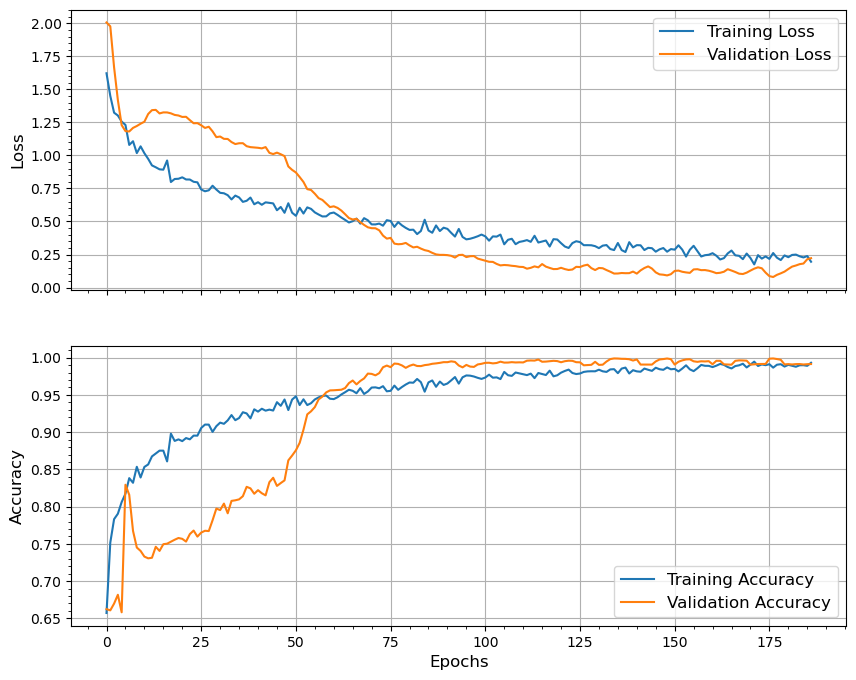

In [12]:
import pandas as pd
df = pd.DataFrame(history.history)
df.head()
# losses[['acc','val_acc']].plot()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,sharex=True, figsize=(10,8))
ax[0].plot(df['loss'],label = 'Training Loss')
ax[0].plot(df['val_loss'],label = 'Validation Loss')
ax[1].plot(df['acc'],label = 'Training Accuracy')
ax[1].plot(df['val_acc'],label = 'Validation Accuracy')
ax[0].legend(loc='best',prop={'size':12})
ax[1].legend(loc='best',prop={'size':12})
ax[0].minorticks_on()
ax[1].minorticks_on()
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Accuracy', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid()
ax[1].grid()
plt.show()

#saving the results
df.to_csv('results.csv')




# print(history.history['val_loss'])
# print(history.history['val_acc'])
# print(history.history['acc'])
# print(history.history['loss'])

c:\Users\noush\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Specificity or TNR 0.9925575836592786
Sensitivity or TPR or Recall 0.9803240740740741
FNR  0.01967592592592593
FPR 0.007442416340721403
Accuracy =  0.9809523809523809


c:\Users\noush\anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


AUC = 0.986434475733788


Text(58.222222222222214, 0.5, 'True Label')

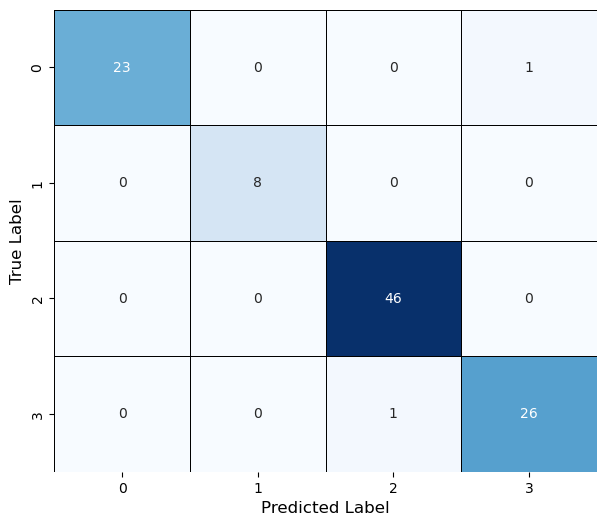

In [13]:
from sklearn.metrics import multilabel_confusion_matrix
#%%
prediction = resnet_model.predict_classes(x_test)

mcm = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction, labels=[0,1,2,3], samplewise=False)
tn = mcm[:,0,0]
tp = mcm[:,1,1]
fp = mcm[:,0,1]
fn = mcm[:,1,0]
specificity = tn/(tn+fp)
print("Specificity or TNR", np.mean(specificity))

sensitivity = tp/(tp+fn)
print("Sensitivity or TPR or Recall", np.mean(sensitivity))

print("FNR ", 1-np.mean(sensitivity))

print("FPR", 1-np.mean(specificity))

from sklearn import metrics
print("Accuracy = ", metrics.accuracy_score(y_test, prediction))
#%%
# use model to predict probability that given y value is 1
y_pred_proba = resnet_model.predict_proba(x_test)

#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

#print AUC score
print("AUC =",auc)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, prediction)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7, 6))
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False, linewidth=0.5,linecolor="black",fmt='')
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)